# COUNTLAND: rank reduction
### Samuel H. Church

The following packages are required to complete the tutorial

In [1]:
import sys
import logging

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
plt.style.use('classic')
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

import seaborn as sns

import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map="viridis")

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 pynndescent==0.5.6


## GET THE DATA

We have used the PBMC3k benchmark dataset.  
`countland` accepts an AnnData object, same as `scanpy` 

In [2]:
#!mkdir data
#!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
#!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
#!mkdir write

adata = sc.read_10x_mtx(
    '../data/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                             # write a cache file for faster subsequent reading

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


... writing an h5ad cache file to speedup reading next time


## IMPORT COUNTLAND
The code is located in `countland.py`

In [3]:
import countland as clnd

In [4]:
import importlib
importlib.reload(clnd)

<module 'countland' from 'c:\\Users\\cwd7\\repos\\countland\\countland-py\\countland\\__init__.py'>

## INITIALIZE COUNTLAND OBJECT

In [5]:
C = clnd.countland(adata)
C.SubsetGenes(np.sum(C.counts,axis=0) > 0) # only genes with counts detected
C.SubsetCells(np.sum(C.counts,axis=1) > 0) # only cells with counts detected
print(C)

AttributeError: module 'countland' has no attribute 'countland'

## CLUSTER

In [ ]:
C.Dot()
C.Cluster(n_clusters=7)

Calculating dot products between rows...
    done.
performing spectral clustering on dot products...
    done.


## SUBSAMPLE GENES

Cells are not sequenced to standard sequencing depth. This is sometimes a problem for downstream comparisons.  

You can subsample all cells to a standard number of counts using `C.Subsample()`. The number of counts must not be larger than the minimum number per cell.

In [ ]:
np.random.seed(84095) # choose a random seed for reproducibility
C.Subsample(n_counts = 500)

## DIMENSIONAL REDUCTION AND LOW RANK APPROXIMATION

In addition to spectral embedding of dot products, there are several other approaches for visualizing cells in reduced dimensions.

### INTEGER MATRIX APPROXIMATION

This method, described [here](https://mtchu.math.ncsu.edu/Research/Papers/bindec05f.pdf), seeks to identify a set of matrices that can be multiplied together to approximate a matrix of integers, here the count matrix. In this way it is similar to other rank reduction methods, like singular value decomposition.

IMA produces three matrices, $\mathrm{U}$, $\mathrm{V}$, and $\Lambda$. The matrix $\mathrm{U}$ has the dimensions cells x features, where the number of features is the target reduction determined by the user. The matrix $\mathrm{V}$ has the dimensions genes x features, and $\Lambda$ is a diagonal scaling matrix. The bounds of the integer values in each matrix can be changed to accomodate the data in question.

We can identify a good target rank by visualizing how many dimensions are required to best approximate the count matrix. 

**Note that this takes some time (~4 mins)**

approximating count matrix using up to 20 features...
    done.


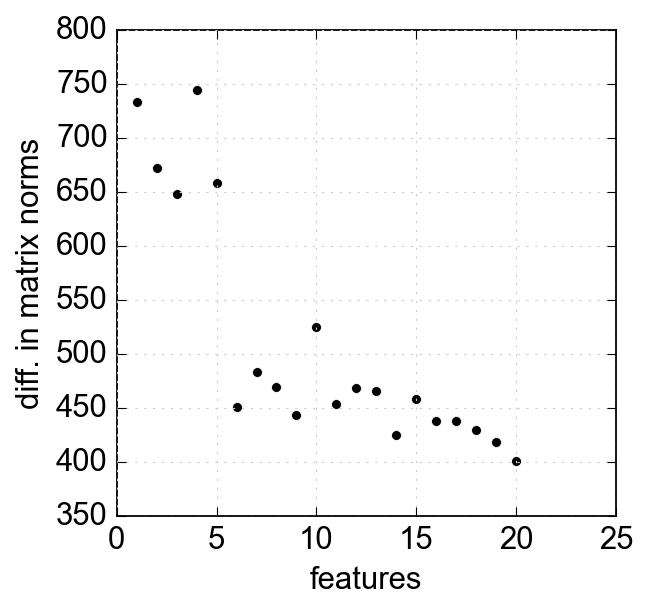

In [ ]:
C.PlotIMAElbow(max_features = 20, u_bounds = [5,10]) # compare results up to 20 features, 
                            # with upper bounds of 5 for matrix U and 10 for matrix V. 

Based on the elbow plot above, the approximation does not appear to improve by adding features beyond ~15.

In [ ]:
C.IMA(features = 15, u_bounds = [5,10])

approximating count matrix...
    done.


We can visualize cells by embedding counts (matrix $\mathrm{C}$) in this reduced space. This is calculated with matrix multiplication $\mathrm{C(V}\Lambda)$.

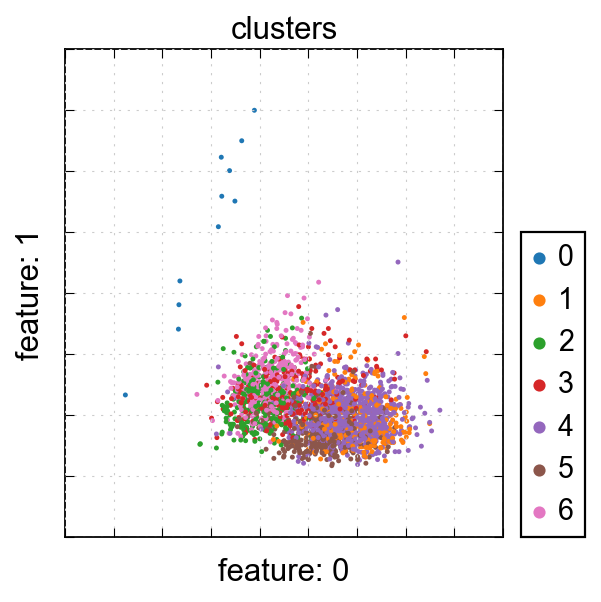

In [ ]:
C.PlotIMA(x = 0, y = 1) # visualize cells using the features 0 and 1
            # Note that features are not necessarily ordered

### COLLAPSING GROUPS OF GENES 

Another method for reducing the dimensions is to collapse groups of genes with similar patterns of counts across cells. Here we can accomplish this by calculating the number of shared counts between all pairs of genes, identifying clusters of genes with similar counts, and then summing counts within clusters.

Because calculating pairwise shared count values is memory intensive, this is performed using a random sample of cells, set with `n_cells`, default `100`. 

In [ ]:
C.SharedCounts(n_clusters=7)

clustering genes based on shared counts...
    done.


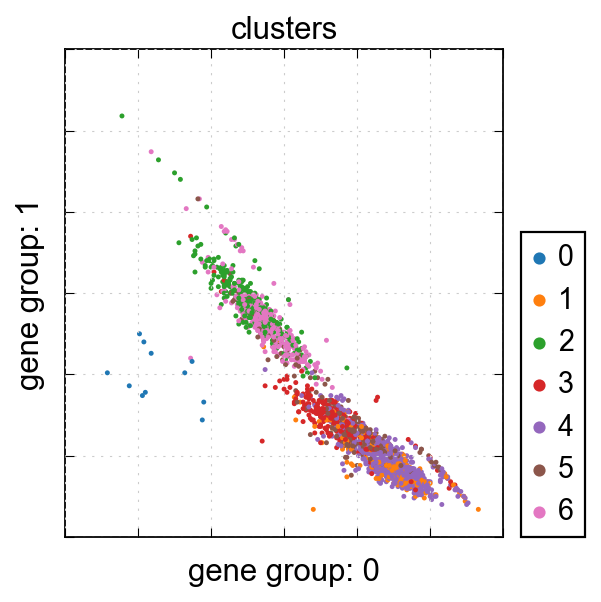

In [ ]:
C.PlotSharedCounts(x = 0, y = 1)

## GLM-PCA

An alternative approach for comparing cells using untransformed counts is generalized linear model based PCA, or GLM-PCA. This has been described for scRNA-seq data [here](https://doi.org/10.1186/s13059-019-1861-6) and implemented [here](https://github.com/willtownes/glmpca-py).

**Note this can take some time.**

In [ ]:
#!pip install git+https://github.com/willtownes/glmpca-py.git@master
from glmpca import glmpca

res = glmpca.glmpca(C.counts.T,2,fam="poi") # embed in 2 dimensions and use a Poisson model

In [ ]:
plt.figure(figsize = (6,6))

g = sns.scatterplot(x = res['factors'][:,0], # embeddings are stored in res['factors']
                y = res['factors'][:,1],
                hue = C.cluster_labels,
                palette="tab10",
                s =10,
                linewidth=0)
g.legend(loc=(1.04,0))
g.xaxis.set_ticklabels([])
g.yaxis.set_ticklabels([])
g.set(title="GLM-PCA: dot product clusters")

In [ ]:
plt.figure(figsize = (6,6))

g = sns.scatterplot(x = res['factors'][:,0], 
            y = res['factors'][:,1], 
            color = "#CFCFCF",
            s = 5,
            linewidth=0)
sci = np.where(C.counts[:,gene_index]>0)[0]
sns.scatterplot(ax = g,
            x = res['factors'][sci,0], 
            y = res['factors'][sci,1], 
            hue = C.counts[sci,gene_index],
            palette = "viridis",
            s = 10,
            linewidth=0) 
g.legend(loc=(1.04,0))
g.xaxis.set_ticklabels([])
g.yaxis.set_ticklabels([])
g.set(title="GLM-PCA: dot product clusters")